In [1]:
import imports

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns; 
sns.set(
    style="ticks", 
    color_codes=True, 
#    style="darkgrid"
)

from datasets import testloader
from initialisations import skmi2020 as skmi
from kmeans import distance_table
from metrics import accuracy
import nbutils


from sklearn.cluster import KMeans

dataset = testloader._load_local('5_2_1000_r_1.5_010')
#dataset = testloader._load_local('skmi_test')
data = dataset.data
target = dataset.target

C = []
K = 5  #20


def calc_density(point, data):
        
    neighbours = int(len(data)/K) + 1
    dists = distance_table(np.array([point]), data)[0]
    idx = np.argpartition(dists, neighbours)
    subdists = dists[idx[:neighbours]]
    return np.sum(subdists)
    

def find_first_centroid(data):
    """The first promising point"""

    density = [calc_density(point, data) for point in data]    
    return data[np.argmin(density)]


def find_furthest(temp_centroids, data):

    distances = distance_table(data, temp_centroids)
    nearests = np.min(distances, axis=1)
    return data[np.argmax(nearests)]
    
    
to_find = K


while to_find > 1:

    first = find_first_centroid(data)
    C.append(first)

    # my_c = None
    my_c = target

    # the main data
    plt.scatter(data[:, 0], data[:, 1], c=my_c)

    plt.scatter(first[0], first[1], c='cyan')

    temp_centroids = np.array([first])

    while len(temp_centroids) < to_find:
        furthest = find_furthest(temp_centroids, data)

        plt.scatter(furthest[0], furthest[1], c='yellow')
        temp_centroids = np.vstack((temp_centroids, furthest))

    plt.show()
    plt.clf()
    
    # Delete latest
    clustering = np.argmin(distance_table(temp_centroids, data), axis=0)
    mask = np.where(clustering==0)[0]
    data = np.delete(data, mask, axis=0)
    target = np.delete(target, mask, axis=0)
    
    to_find -= 1
    
    
# Finally just get the mean of the remaining points
final = np.mean(data, axis=0)

C.append(final)

#print(C)

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

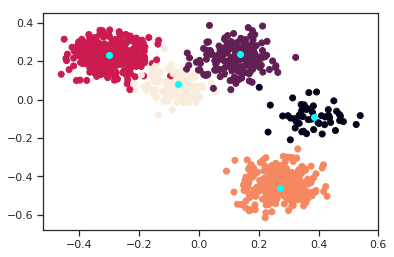

In [2]:

data = dataset.data
my_c = dataset.target
plt.scatter(data[:, 0], data[:, 1], c=my_c)

for centroid in C:
    plt.scatter(centroid[0], centroid[1], c='cyan')